In [5]:
import os
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [77]:
DATA_DIR = f"prefill_plots_overlaid"

METHODS = [
    "fcfs",
    "fcfs_mlfq",
    # "srpt_fcfs",
    "srpt_mlfq",
]

MIN_LEN = 1000
FILTER_COL = "gen_len"
PERCENTILE = 1.0

# BENCHMARK_DIRS = [
#     os.path.join("bs_16_sched_32/", f"{method}_{RPS}_rps") for method in METHODS
# ]


# PREFILL_BENCHMARK_FILES = [
#     os.path.join(benchmark_dir, "benchmark_results.csv") for benchmark_dir in BENCHMARK_DIRS
# ]

In [78]:
import numpy as np


def compute_stats(samples):

  if len(samples) == 0:
    return {
        "mean": 0,
        "std": 0,
        "50th_percentile": 0,
        "90th_percentile": 0,
        "99th_percentile": 0
    }

  stats = {}
  stats["mean"] = np.mean(samples)
  stats["std"] = np.std(samples)

  percentiles = np.quantile(samples, [0.5, 0.9, 0.99])
  stats["50th_percentile"] = percentiles[0]
  stats["90th_percentile"] = percentiles[1]
  stats["99th_percentile"] = percentiles[2]

  return stats


def compute_df_stats(df_path):
    results_df = pd.read_csv(df_path)[:1000]

    # Compute threshold value for filter_col.
    filter_col_vals = results_df[FILTER_COL].to_list()
    threshold_val = np.quantile(filter_col_vals, [PERCENTILE])[0]

    results_df = results_df.loc[results_df[FILTER_COL] < threshold_val]
    
    return compute_stats(results_df["JCT"])

In [79]:
RPS = [1, 2, 4, 8]
STATS = {}

for rps in RPS:

    for method in METHODS:
        # Load the results df.
        results_path = os.path.join("bs_16_sched_32", f"{method}_{rps}_rps", "benchmark_results.csv")
        curr_stats = compute_df_stats(results_path)

        for stat_name, stat_val in curr_stats.items():
            if stat_name not in STATS:
                STATS[stat_name] = {}

            if method not in STATS[stat_name]:
                STATS[stat_name][method] = []

            STATS[stat_name][method].append(stat_val)
            
    # for stat_name in STATS.keys():
    #     if method_name not in STATS[stat_name]:
    #         STATS[stat_name][method_name] = []

    #     STATS[stat_name][method_name].append(row[stat_name])

print(STATS["mean"])

{'fcfs': [25.202491491491493, 81.44854554554556, 82.92892592592592, 246.90347747747745], 'fcfs_mlfq': [24.757812812812812, 97.47191691691691, 105.81783383383383, 285.0827727727728], 'srpt_mlfq': [24.40001301301301, 99.77638538538538, 99.05567067067066, 284.3478388388388]}


In [91]:
for stat_name, stat_vals in STATS.items():
    print(stat_name)
    for method_name, method_stats in stat_vals.items():
        print(f"{method_name}\t{method_stats[1]}")
    print()

mean
fcfs	81.44854554554556
fcfs_mlfq	97.47191691691691
srpt_mlfq	99.77638538538538

std
fcfs	40.1465770422322
fcfs_mlfq	69.29855028827198
srpt_mlfq	74.19589710505461

50th_percentile
fcfs	79.134
fcfs_mlfq	86.73
srpt_mlfq	93.599

90th_percentile
fcfs	134.4776
fcfs_mlfq	200.23000000000002
srpt_mlfq	204.43240000000003

99th_percentile
fcfs	192.17117999999996
fcfs_mlfq	279.85061999999994
srpt_mlfq	307.3574999999999



In [75]:
print(STATS.keys())

dict_keys(['mean', 'std', '50th_percentile', '90th_percentile', '99th_percentile'])


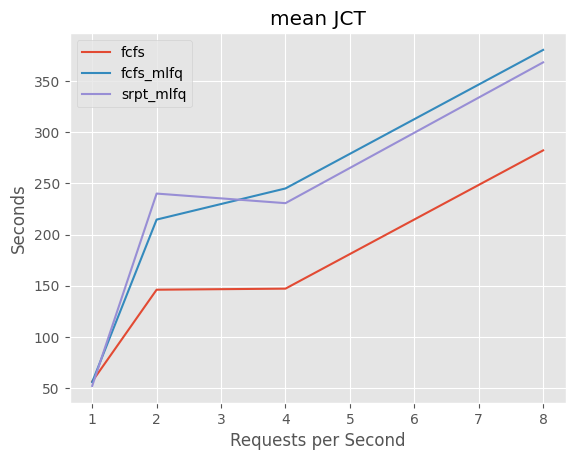

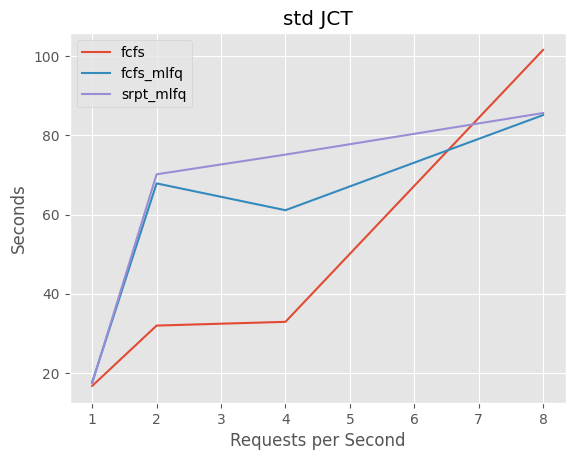

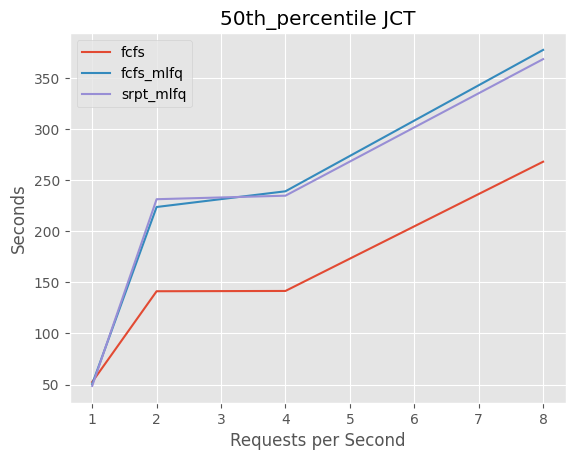

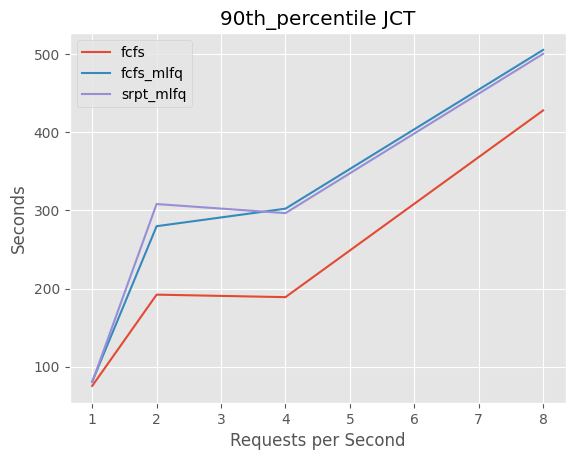

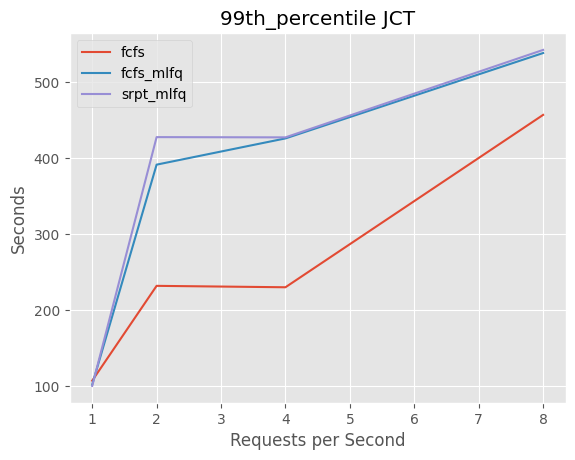

In [76]:
for stat_name, plot_dict in STATS.items():
    plt.cla()
    for method_name, method_stats in plot_dict.items():
        plt.plot(RPS, method_stats, label=method_name)
    
    plt.title(f"{stat_name} JCT")
    plt.xlabel("Requests per Second")
    plt.ylabel("Seconds")
    plt.legend()
    plt.savefig(f"JCT-{stat_name}-gen_len_larger_percentile_{PERCENTILE}-without_srpt_fcfs.png")
    plt.show()